In [ ]:
%pip install keras-tuner --upgrade

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib import animation  # animate 3D plots
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
dataset = pd.read_csv("products.csv")
dataset = dataset.sample(frac=1)
dataset_features = dataset.copy()
dataset_label = dataset_features.pop('MTTF')

In [ ]:
features_max = dataset_features.max()
labels_max = dataset_label.max()
dataset_features /= features_max
dataset_label /= dataset_label.max()

In [ ]:
inputs = {name:tf.keras.Input(shape=(1,), name=name, dtype=tf.float32) for name, _ in dataset_features.items()}
inputs

In [ ]:
numeric_inputs = {name: input_feature for name, input_feature in inputs.items() if input_feature.dtype == tf.float32}
numeric_inputs

In [ ]:
x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(dataset_features[numeric_inputs.keys()]))
# all_numeric_inputs = norm(x)
preprocessed_inputs = [x]

In [ ]:
preprocessing_layer = tf.keras.Model(inputs, preprocessed_inputs, name="ProcessData")

In [ ]:
preprocessing_layer.summary()

In [ ]:
items_features_dict = {name: np.array(value) for name, value in dataset_features.items()}

# grab two samples
two_sample_dict = {name:values[1:3, ] for name, values in items_features_dict.items()}
two_sample_dict

In [ ]:
two_sample_fitted = preprocessing_layer(two_sample_dict)
two_sample_fitted


In [ ]:
full_dim = two_sample_fitted.shape.as_list()[1]

encoding_dim1 = 64
encoding_dim2 = 16
encoding_dim3 = 3
encoder_input_data = keras.Input(shape=(full_dim,))

# the encoded representation of the input
encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)
# Note that encoded_layer3 is our 3 dimensional "clustered" layer, which we will later use for clustering
encoder_output = keras.layers.Dense(encoding_dim3, activation='relu', name="ClusteringLayer")(encoded_layer2)

encoder = keras.Model(encoder_input_data, encoder_output, name="encoder")

encoder.summary()

decoder_input = keras.Input(shape=(encoding_dim3,))

decoded_layer3 = keras.layers.Dense(encoding_dim2, activation='relu')(decoder_input)
decoded_layer2 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer3)
decoder_output = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer2)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(full_dim,))
encoded_input = encoder(autoencoder_input)
decoded_input = decoder(encoded_input)
autoencoder = keras.Model(autoencoder_input, decoded_input, name="autoencoder")
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss=tf.keras.losses.mean_squared_error)
tf.keras.utils.plot_model(model=autoencoder, rankdir="LR", dpi=130, show_shapes=True, to_file="autoencoder.png")

In [ ]:
items = preprocessing_layer(items_features_dict)

train_data, test_data, train_labels, test_labels = train_test_split(items.numpy(), dataset_label, train_size=0.6, random_state=5)
history = autoencoder.fit(train_data, train_data, epochs=200, batch_size=10, shuffle=False, validation_data=(test_data, test_data))

In [ ]:
encoded_items = encoder(items)

# choose number of clusters K:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(init='k-means++', n_clusters=k, n_init=10)
    km.fit(encoded_items)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.vlines(ymin=0, ymax=20000, x=5, colors='red')
plt.text(x=5.2, y=21000, s="optimal K=8")
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show()

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit(encoded_items)
P = kmeans.predict(encoded_items)

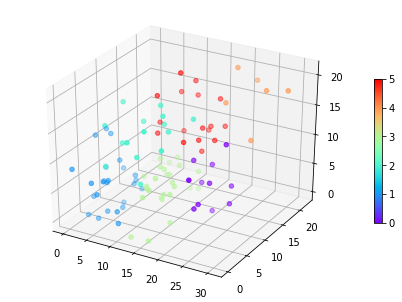

In [325]:
encoded_fig = plt.figure()
ax = Axes3D(encoded_fig)
p = ax.scatter(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c=P, marker="o", picker=True, cmap="rainbow")
plt.colorbar(p, shrink=0.5)
plt.show()

def rotate(angle):
    ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(encoded_fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('kmeans_fig.gif', writer=animation.PillowWriter(fps=12))

In [326]:
decoded_items = decoder(encoded_items)
decoded_items[0]*features_max

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1.        , 0.9542403 , 0.1034137 , 0.74084675, 0.30305514,
       1.        , 0.9975011 , 1.        , 0.03319836, 0.99346465,
       0.00976196, 0.59227103, 1.        , 1.        , 0.88789606,
       1.        , 1.        , 0.09578875, 0.03402653, 0.09520081,
       1.        , 0.07520518, 1.        , 0.9717772 , 1.        ,
       0.7663655 , 0.25362042, 0.9999988 , 0.99992377, 0.9996997 ,
       1.        , 1.        , 0.38274345, 1.        , 0.00181881,
       0.15138787, 0.05877104, 0.10807157, 0.93606454, 0.13471797,
       1.        , 0.74751335, 0.52576804, 1.        , 0.00484228,
       0.9924837 , 0.9010422 , 1.        , 0.99559   , 0.59025913],
      dtype=float32)>

In [ ]:
items[0]

In [ ]:
output = ""
for feature in items[0]:
    if feature >= 1:
        output += '"1",'
    else:
        output += '"0",'